In [1]:
import pandas as pd
import numpy as np
import requests
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
plt.style.use("seaborn")

/home/pnietoramos/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Defining Features and Classifier

In [2]:
df_common = pd.read_csv("Trees_common.csv", index_col=False)

In [3]:
df_common.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Cover_Type,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,0,29


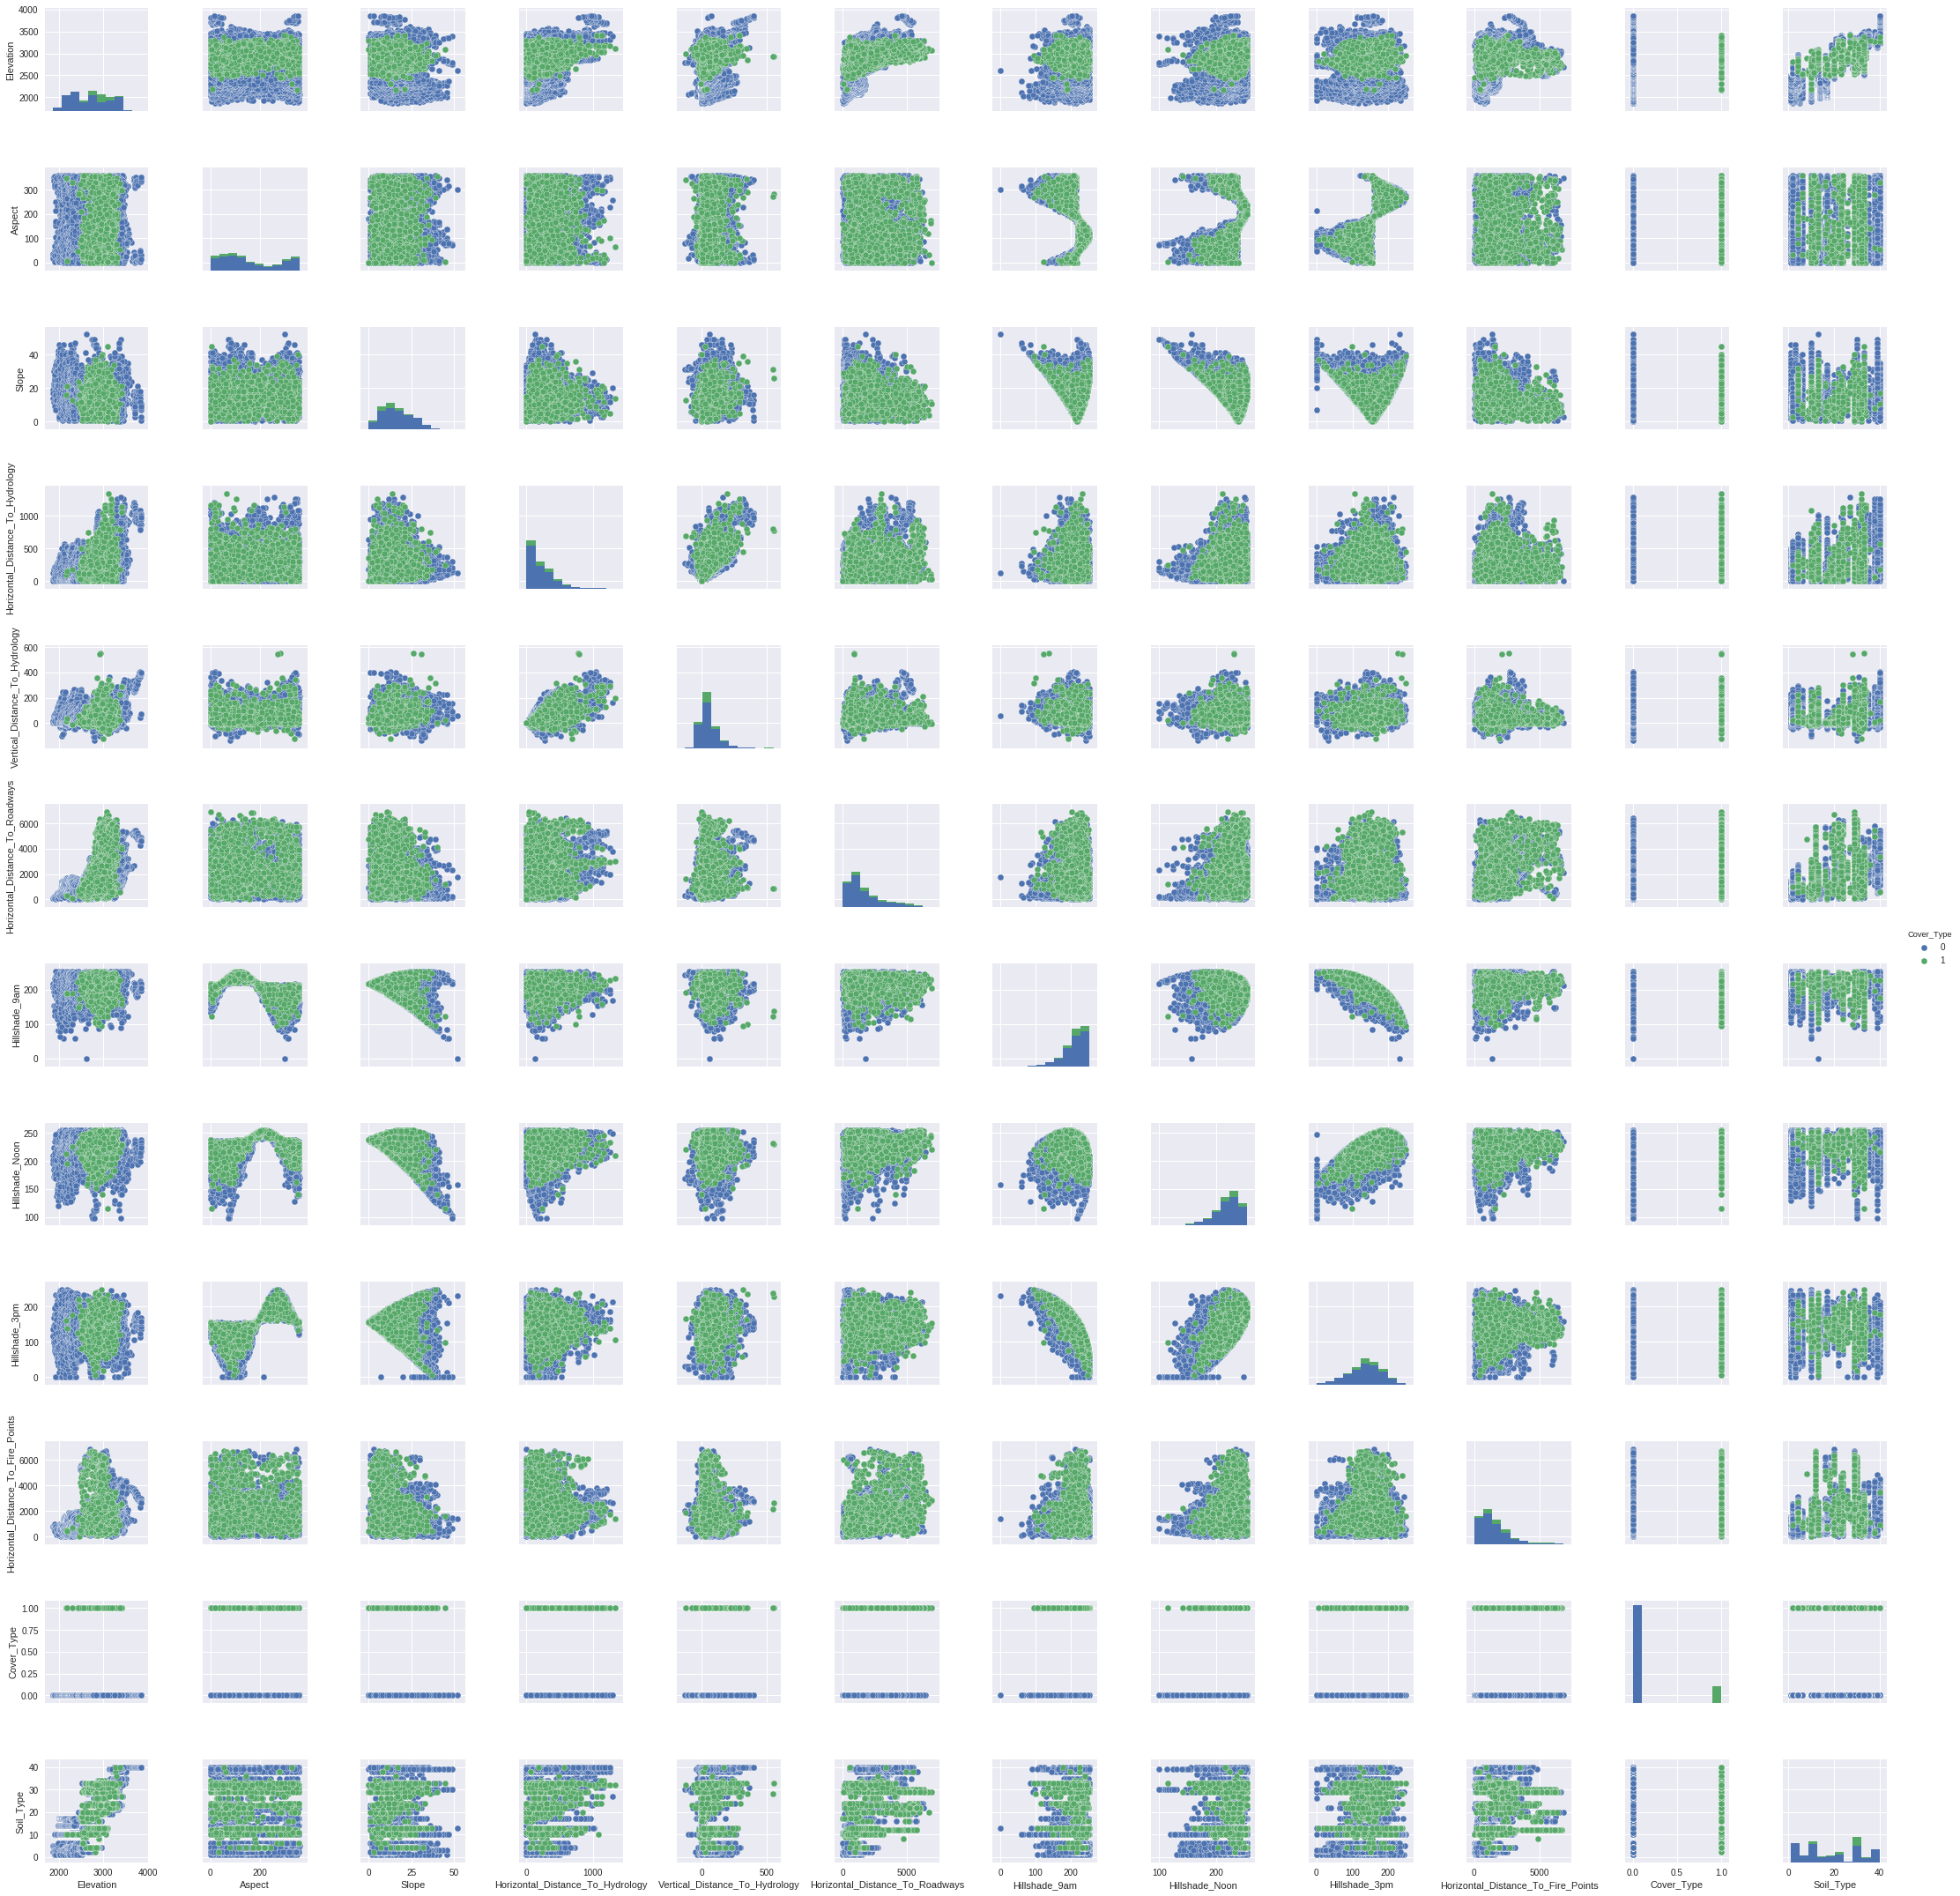

In [4]:
sns.pairplot(df_common.iloc[:10000,:], hue='Cover_Type');

In [5]:
#sns.stripplot(x='Elevation',y='Cover_Type', jitter=True,data=df_common,alpha=0.1);

In [6]:
X = df_common.drop("Cover_Type",axis=1)
y = df_common["Cover_Type"]

In [7]:
y[y==1].count()/y.count()

0.48759922342395684

In [8]:
X.head(1)

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Soil_Type
0,2596,51,3,258,0,510,221,232,148,6279,29


In [9]:
#Splitting the set (test = 0.3) in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30,stratify=y, random_state=4444)

In [10]:
#scaling the features
sca = StandardScaler()
sca.fit_transform(X_train)
sca.transform(X_test);

In [11]:
# Scores for the test sets for an estimator
def alg_class(estimator, X_train, y_train, X_test, y_test):
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    acc = accuracy_score(y_pred,y_test)
    rec = recall_score(y_pred,y_test)
    prec = precision_score(y_pred,y_test)
    f1 = f1_score(y_pred,y_test)
    
    return acc, rec, prec, f1
    #return ("Accuracy: " + str(acc)), ("Recall: " + str(rec)), ("Precision: " + str(prec)), ("F1: " + str(f1))

In [12]:
def plot_scores_knn(k, acc_, rec_, prec_, f1_):
    fig, axes = plt.subplots(1, 4, figsize=(30,6))
    axes[0].plot(k,acc_)
    axes[0].set_xlabel("k")
    axes[0].set_ylabel("Accuracy")

    axes[1].plot(k,rec_)
    axes[1].set_xlabel("k")
    axes[1].set_ylabel("Recall")

    axes[2].plot(k,prec_)
    axes[2].set_xlabel("k")
    axes[2].set_ylabel("Precision")

    axes[3].plot(k,f1_)
    axes[3].set_xlabel("k")
    axes[3].set_ylabel("F1")


In [18]:
# Trying with nearest neighbors k = 1-40
acc_ =[]
rec_ =[]
prec_ =[]
f1_ =[]
k_ = []
for item in range(1,21):
    k_.append(int(item)) 
    acc, rec, prec, f1 = alg_class(KNeighborsClassifier(item), X_train, y_train, X_test, y_test)
    acc_.append(acc)
    rec_.append(rec)
    prec_.append(prec)
    f1_.append(f1)
    print(item)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


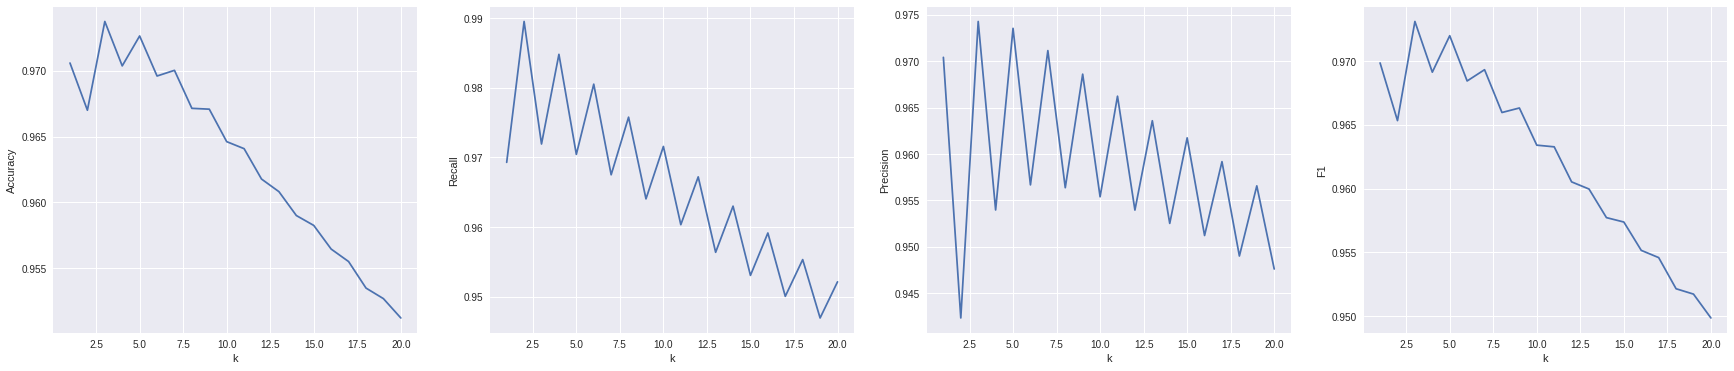

In [19]:
plot_scores_knn(k_, acc_, rec_, prec_, f1_)

In [20]:
#Now with cross validation
param_grid = {'n_neighbors': list(range(1,21))}
grid = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid, cv=5, n_jobs=1, scoring="accuracy")
grid.fit(X_train, y_train)
print(grid.best_score_)
grid.best_estimator_

0.9702243378541853


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [21]:
y_pred = grid.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_pred,y_test)))
print("Recall: " + str(recall_score(y_pred,y_test)))
print("Precision: " + str(precision_score(y_pred,y_test)))
print("F1 score: " + str(f1_score(y_pred,y_test)))


Accuracy: 0.9737412796034515
Recall: 0.9719238940338275
Precision: 0.9742910930697729
F1 score: 0.9731060539289135


In [13]:
#Including only important features from random forest analysis
col_in = ["Elevation","Horizontal_Distance_To_Roadways","Horizontal_Distance_To_Fire_Points", "Soil_Type",
          "Horizontal_Distance_To_Hydrology","Vertical_Distance_To_Hydrology"]
X_train_in = X_train[col_in]
X_test_in = X_test[col_in]
acc_ =[]
rec_ =[]
prec_ =[]
f1_ =[]
k_ = []
for item in range(1,21):
    k_.append(int(item)) 
    acc, rec, prec, f1 = alg_class(KNeighborsClassifier(item), X_train_in, y_train, X_test_in, y_test)
    acc_.append(acc)
    rec_.append(rec)
    prec_.append(prec)
    f1_.append(f1)
    print(item)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


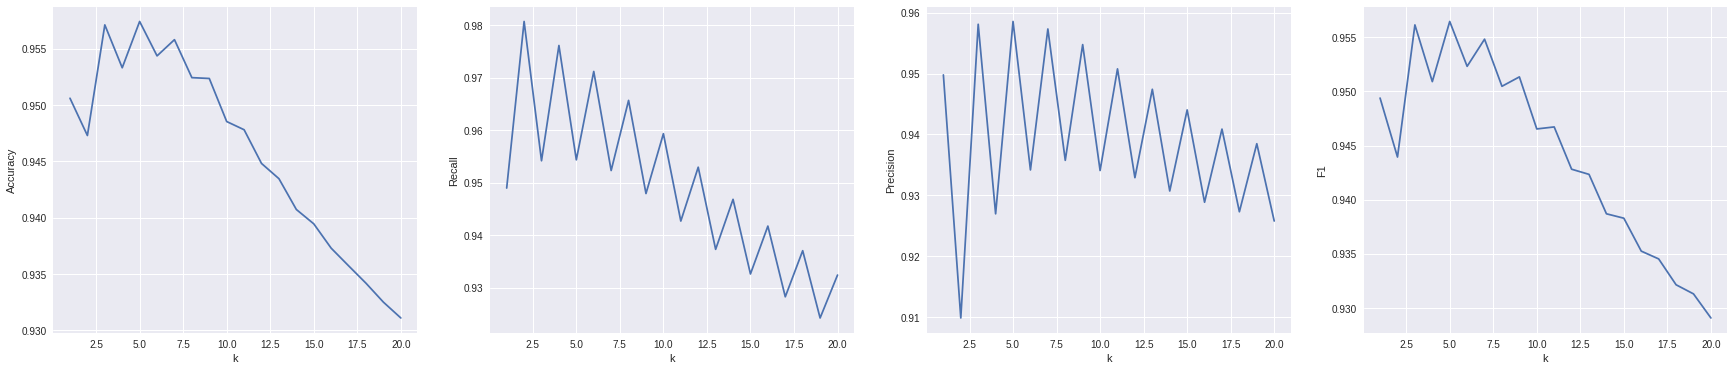

In [14]:
plot_scores_knn(k_, acc_, rec_, prec_, f1_)

Not better than the one with all features!!!